In [1]:
import asyncio
import websockets
import json
import pandas as pd
import nest_asyncio
import matplotlib.pyplot as plt
nest_asyncio.apply()
import warnings
import numpy as np
import datetime
from utils import collect_all_instruments_ids, collect_single_instrument_data
warnings.filterwarnings("ignore")

## Соберем все id-щники и опционы, которым они соответсвуют

In [2]:
# все id-шники
instruments_df = collect_all_instruments_ids()
instruments_df.head(5)

,instrument_name,instrument_id
0,BTC-24OCT22-15000-C,140131
1,BTC-24OCT22-15000-P,140132
2,BTC-24OCT22-16000-C,140133
3,BTC-24OCT22-16000-P,140134
4,BTC-24OCT22-17000-C,140136


## Собираем данные по конкретному опциону

In [3]:
# по конкретному опциону
single_option = collect_single_instrument_data(instrument_id = 140054, number_of_ticks = 100)
single_option.head(5)

2022-10-23 13:42:55.798 | INFO     | utils:call_api:68 - Collected 100 ticks for id = 140054


,instrument_name,timestamp,underlying_price,mark_iv,mark_price,best_bid_price,best_ask_price,human_timestamp,strike
0,BTC-23OCT22-15000-C,1666512000014,19159.46,210.0,0.2171,0.0,0.0,2022-10-23 11:00:00.014000,15000


## Собираем по одному тику для каждого опциона, чтобы узнать все страйки и их рыночные волатильности

2022-10-23 13:47:26.185 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 136057
2022-10-23 13:47:26.591 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 136058
2022-10-23 13:47:27.231 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 135676
2022-10-23 13:47:27.643 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 135677
2022-10-23 13:47:28.077 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 136226
2022-10-23 13:47:28.473 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 136227
2022-10-23 13:47:28.907 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 135678
2022-10-23 13:47:29.309 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 135679
2022-10-23 13:47:29.760 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 135680
2022-10-23 13:47:30.209 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 135681
2022-10-23 13:47:30.621 | INFO     | utils:call_api:68 - Collected 1 ticks for id = 135682

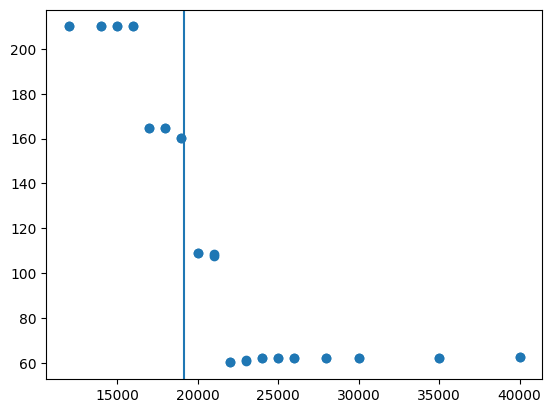

In [10]:
random_instrument = instruments_df.sample(1).iloc[0]["instrument_name"]
single_strike = instruments_df[
    (instruments_df["instrument_name"].str.startswith(random_instrument[0:11])) 
#     (instruments_df["instrument_name"].str.endswith(random_instrument[-1]))
]
single_strike_ids = single_strike.instrument_id.to_list()

options = pd.DataFrame(columns = single_option.columns.values)
for op_id in single_strike_ids:
    option = collect_single_instrument_data(instrument_id = op_id, number_of_ticks = 1)
    options = options.append(option)
    
plt.scatter(options["strike"], options["mark_iv"])
plt.axvline(x=option.iloc[0]["underlying_price"])
plt.show()

In [12]:
options.to_pickle("data/BTC-25NOV22.pkl")